# Introduction

This notebook will provide further cleaning for all three datasets. Most sections end with exporting the dataset to a file for later use.

This notebook will combine the satellite chlorophyll data downloaded in [`ChesapeakeBaySatellite.ipynb`]('notebooks/APIs/ChesapeakeBaySatellite.ipynb') with the buoy based weather data from [`data/buoy_aggregate.csv`]('../../data/buoy_aggregate.csv') in order to use the data in our model. It will also prepare the [`data/water_cleaned.csv`]('../data/water_cleaned.csv') data for the model.

In [1]:
import pandas as pd
import numpy as np
import json
import xarray as xr
from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import QuantileTransformer


import xarray as xr
import matplotlib.pyplot as plt

import logging
from tqdm import tqdm  # For progress bar
# Configure logging instead of print
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import torch

We will read in the buoy data and water quality data from CSV. In both cases, we need to turn data and time columns into a datatime column numeric data. However, the columns are organized differently, so need to be processed differently.


In [3]:
# Function to process buoy data
def process_buoy_datetime(df, year_col, month_col, day_col, hour_col, minute_col, second_col):
    # Create a copy of the original DataFrame to avoid editing it
    df_copy = df.copy()

    # Combine the datetime components into a single string
    combined_col = df_copy[year_col].astype(str) + '-' + \
                           df_copy[month_col].astype(str).str.zfill(2) + '-' + \
                           df_copy[day_col].astype(str).str.zfill(2) + ' ' + \
                           df_copy[hour_col].astype(str).str.zfill(2) + ':' + \
                           df_copy[minute_col].astype(str).str.zfill(2) + ':' + \
                           df_copy[second_col].astype(str).str.zfill(2)

    # Convert to a datetime object
    df_copy['timestamp'] = pd.to_datetime(combined_col, format='%Y-%m-%d %H:%M:%S', errors="coerce")

    # Drop the original datetime component columns
    df_copy.drop(columns=[year_col, month_col, day_col, hour_col, minute_col, second_col], inplace=True)

    return df_copy


# Function to process water quality data
def process_water_datetime(df, date_col, time_col):
    # Create a copy of the original DataFrame to avoid editing it
    df_copy = df.copy()

    # Combine date and time strings
    combined_col = df_copy[date_col] + " " + df_copy[time_col]

    # Convert the combined date and time strings into a datetime object
    df_copy['timestamp'] = pd.to_datetime(combined_col, format='%m/%d/%Y %H:%M:%S', errors="coerce")

    # Drop the original date and time columns
    df_copy.drop(columns=[date_col, time_col], inplace=True)

    return df_copy

# Satelitte and buoy data

## Preparing the satellite data

We will read in the satellite data as an xarray. This data has coordinates

>Coordinates:
>  * x        (x)  
>  * y        (y)  
>  *  lat      (y, x) 
>  *  lon      (y, x) 
>  * time     (time) 
>  * level    (level) 

where `x` is projection_x_coordinate in meters, `y` is projection_y_coordinate in meters, `lat` is latitude, `lon` is longitude, `time` is a `datetime64` timestamp, and `level` is the height of the measurement from the surface. All `level` values are `0`, indicating surface measurements.

We do not need two set of location coordinates, so we will regrid the data to use `lat` and `lon` as the coordinate variables. This will match with the coordinates from our other datasets. We will also rename `level` to `depth`.

In [3]:
satellite_data = xr.open_dataset('../../data/combinedSatelitte_unmasked.nc4')

satellite_data

<xarray.Dataset>
Dimensions:      (x: 243, y: 358, time: 2767, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y            (y) float64 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
    lat          (y, x) float64 ...
    lon          (y, x) float64 ...
  * time         (time) datetime64[ns] 2014-08-28T17:55:08 ... 2022-10-30T17:...
  * level        (level) float64 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 ...
    time_bounds  (time, n_vals) datetime64[ns] ...
    chlor_a      (time, level, y, x) float32 ...

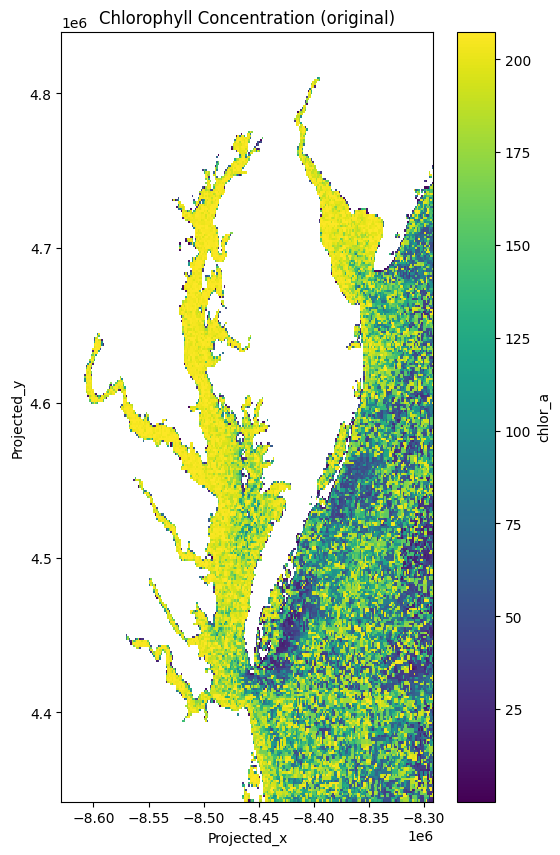

In [4]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data['chlor_a'].max(dim='time', skipna=True).isel(level=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (original)')
plt.xlabel('Projected_x')
plt.ylabel('Projected_y')

# Show the plot
plt.show()

In [5]:
# Extract the lat/lon coordinates
lon_coords = satellite_data['lon'].values  # Longitude coordinates
lat_coords = satellite_data['lat'].values  # Latitude coordinates

# Create a 2D grid from the 1D lat/lon arrays
# lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

In [6]:
def xarray_select_variables(ds):
    
    latitude = ds['lat'].values
    longitude = ds['lon'].values

    spatial_dims = ('y', 'x')
    
    # Stack the 'chlor_a' variable based on detected spatial dimensions and get the flattened array
    var_flat = ds['chlor_a'].stack(spatial=spatial_dims).values


    # Remove duplicate lat/lon points to ensure unique lat/lon coordinates if needed
    lat_unique, lon_unique = np.unique(latitude)[::-1], np.unique(longitude)

    # Rename level
    ds = ds.rename({'level':'depth'})

    # Initialize the new dataset with reshaped data
    new_ds = xr.Dataset(
        {
            'chlor_a': (('time', 'depth', 'lat', 'lon'), var_flat.reshape(ds['time'].size, ds['depth'].size, len(lat_unique), len(lon_unique)))
        },
        coords={
            'time': ds['time'],
            'depth': ds['depth'],
            'lat': lat_unique,
            'lon': lon_unique
        }
    )

    # Step 6: Dynamically copy metadata for all data variables
    for var in ds.data_vars:
        # Check if the variable exists in the new dataset and copy metadata
        if var in new_ds.data_vars:
            new_ds[var].attrs = ds[var].attrs  # Copy the metadata dynamically

    # Step 7: Dynamically copy metadata for all coordinates (no hardcoding)
    for coord in ds.coords:
        # If the coordinate exists in the new dataset, copy metadata
        if coord in new_ds.coords:
            new_ds[coord].attrs = ds[coord].attrs

    new_ds['lat'].attrs = ds['lat'].attrs  # Copy longitude metadata

    new_ds['lon'].attrs = ds['lon'].attrs  # Copy longitude metadata

    new_ds.attrs = ds.attrs

    # Check the new dataset structure
    return new_ds


In [7]:
satellite_data_reindex= xarray_select_variables(satellite_data)
satellite_data_reindex

<xarray.Dataset>
Dimensions:  (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time     (time) datetime64[ns] 2014-08-28T17:55:08 ... 2022-10-30T17:52:40
  * depth    (depth) float64 0.0
  * lat      (lat) float64 40.01 40.0 39.99 39.98 ... 36.52 36.51 36.5 36.49
  * lon      (lon) float64 -77.51 -77.5 -77.49 -77.47 ... -74.51 -74.5 -74.49
Data variables:
    chlor_a  (time, depth, lat, lon) float32 nan nan nan ... 0.2937 0.3537

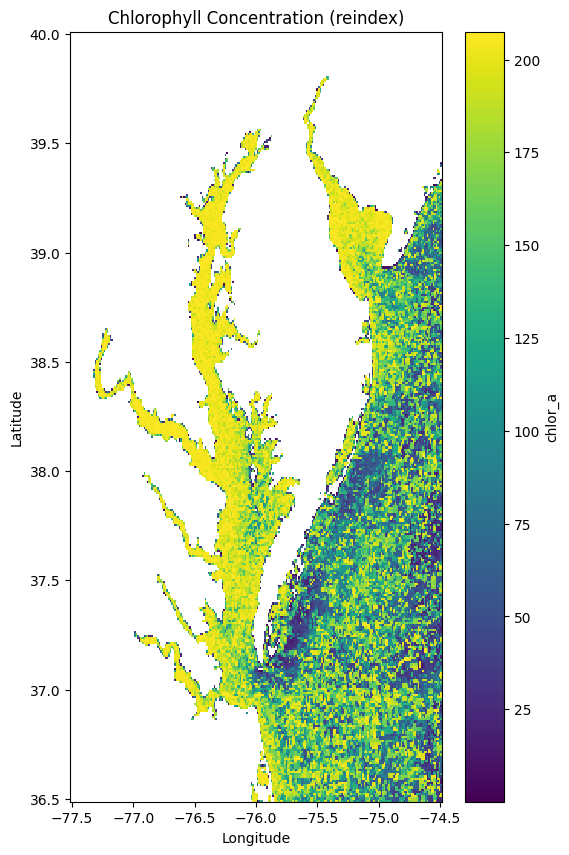

In [8]:
plt.figure(figsize=(6, 10))

# Calculate the mean across the time dimension for the current variable
variable_mean = satellite_data_reindex['chlor_a'].max(dim='time', skipna=True).isel(depth=0)

# Plot the variable using xarray
variable_mean.plot(cmap='viridis')

# Add labels and title
plt.title('Chlorophyll Concentration (reindex)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [9]:
for var in satellite_data_reindex.data_vars:
    data = satellite_data_reindex[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")

Percentage of NaN values in 'chlor_a': 87.22%


## Preparing the buoy data

### Read and clean the dataset

In [224]:
# read in Jun's buoy data
buoy_df = pd.read_csv('../../data/plank_ChesapeakeBay_all_buoys.csv')
buoy_timestamped = process_buoy_datetime(buoy_df, 'Sample_year', 'Sample_month', 'Sample_day', 'Sample_hour', 'Sample_minute', 'Sample_second')

KeyboardInterrupt: 

The buoy data also contains columns with `QC` that describe the quality of the reading. Since we do not need that information, let's drop those columns.

In [98]:
buoy_timestamped = buoy_timestamped.loc[:, ~buoy_timestamped.columns.str.contains('QC')]

There were also some issues with the way the data was combined, let's fix that.

In [99]:
buoy_timestamped = buoy_timestamped.drop(columns=['Latitude_y','Longitude_y'])


In [106]:
start_date = pd.to_datetime(satellite_data_reindex['time'].min().item())
end_date = pd.to_datetime(satellite_data_reindex['time'].max().item())

buoy_timestamped = buoy_timestamped[(buoy_timestamped['timestamp'] >= start_date) & (buoy_timestamped['timestamp'] <= end_date)]

2014-08-28 17:55:08 2022-10-30 17:52:40


And some more cleaning to remove invalid latitude and longitude measurements.

In [107]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(buoy_data):
    # Filter rows based on column: 'Longitude_x'
    buoy_data = buoy_data[(buoy_data['Longitude_x'].notna()) & (buoy_data['Longitude_x'] < -70) & (buoy_data['Longitude_x'] > -80)]
    # Filter rows based on column: 'Latitude_x'
    buoy_data = buoy_data[(buoy_data['Latitude_x'].notna()) & (buoy_data['Latitude_x'] > 35) & (buoy_data['Latitude_x'] < 40)]
    # Rename column 'Latitude_x' to 'Latitude'
    buoy_data = buoy_data.rename(columns={'Latitude_x': 'Latitude','Longitude_x': 'Longitude'})
    return buoy_data

buoy_data_clean = clean_data(buoy_timestamped.copy())
buoy_data_clean.columns

Index(['Latitude', 'Longitude', 'Air Temperature', 'Air pressure', 'Humidity',
       'Wind speed', 'Wind Direction', 'Temperature', 'Salinity',
       'Chlorophyll', 'Turbidity', 'Oxygen', 'Significant wave height',
       'Wave from direction', 'Wave period', 'North surface currents',
       'East surface currents', 'timestamp'],
      dtype='object')

The next step is preparing the data to align with our satellite data.  Since the buoys move a bit, the latitude and longitude values should be rounded before aggregation. The satellite data uses two decimal places, and that should also be reasonable for the buoy data.Since the buoy data is taken every 6-60 minutes, depending on the parameter, and the satellite data is roughly daily, we will use the daily mean measurements.

In [108]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(buoy_data_clean):
    # Round column 'Latitude' (Number of decimals: 2)
    buoy_data_clean = buoy_data_clean.round({'Latitude': 2})
    # Round column 'Longitude' (Number of decimals: 2)
    buoy_data_clean = buoy_data_clean.round({'Longitude': 2})
    return buoy_data_clean

buoy_data_rounded = clean_data(buoy_data_clean.copy())
buoy_data_rounded.head()

,Latitude,Longitude,Air Temperature,Air pressure,Humidity,Wind speed,Wind Direction,Temperature,Salinity,Chlorophyll,Turbidity,Oxygen,Significant wave height,Wave from direction,Wave period,North surface currents,East surface currents,timestamp
245337,38.96,-76.45,26.5,1015.03,58.3,4.7,308.0,26.6,9.55,8.99,3.18,7.66,0.18,4.0,2.1,4.35,-30.97,2014-08-28 18:00:00
245338,38.96,-76.45,26.6,1015.04,58.4,5.0,309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-28 18:10:00
245339,38.96,-76.45,26.7,1015.05,61.3,5.3,314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-28 18:20:00
245340,38.96,-76.45,26.7,1014.92,61.2,4.3,309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-28 18:30:00
245341,38.96,-76.45,26.8,1014.76,62.2,5.4,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-28 18:40:00


In [109]:
# Assuming buoy_data is your DataFrame
# buoy_data_rounded['timestamp'] = pd.to_datetime(buoy_data_rounded['timestamp'])  # Convert to datetime if not already
buoy_data_rounded.set_index('timestamp', inplace=True)  # Set the timestamp as the index

# Group by date and latitude/longitude, aggregating measurement columns
daily_aggregate = (
    buoy_data_rounded.groupby([buoy_data_rounded.index.date, 'Latitude', 'Longitude'])
    .agg('mean')  # Default behavior is to calculate the mean, ignoring NaNs
    .reset_index()
)

# Rename the date column for clarity
daily_aggregate.rename(columns={'level_0': 'Date'}, inplace=True)


Finally, we will only retain parameters with data in at least 10% of the rows.

In [110]:
threshold = 0.1

missing_percentage = daily_aggregate.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
daily_aggregate = daily_aggregate[columns_to_keep]

print('Remaining columns:', daily_aggregate.columns)

Remaining columns: Index(['Date', 'Latitude', 'Longitude', 'Air Temperature', 'Air pressure',
       'Wind speed', 'Wind Direction'],
      dtype='object')


In [111]:
daily_aggregate.dtypes

Date                object
Latitude           float64
Longitude          float64
Air Temperature    float64
Air pressure       float64
Wind speed         float64
Wind Direction     float64
dtype: object

Now we can save this aggregated data in a CSV to access later.

In [112]:
daily_aggregate.to_csv('../../data/buoy_aggregate.csv', index=False)

### Aggregate by date

We will read in the buoy data, then create a dictionary that aggreates the data by day. This dictionary will save time when aligning with the satellite data, as the grouping csv rows takes time.

In [11]:
# Load buoy data from CSV
buoy_data = pd.read_csv('../../data/buoy_aggregate.csv')

buoy_data['Date'] = pd.to_datetime(buoy_data['Date'])
buoy_data.columns

Index(['Date', 'Latitude', 'Longitude', 'Air Temperature', 'Air pressure',
       'Wind speed', 'Wind Direction'],
      dtype='object')

Now we need to group the rows by date so that we can merge with the corresponding satellite data.

In [12]:
def preprocess_dataframe_by_date(df):
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # Group DataFrame by date
    start_date = pd.to_datetime(satellite_data_reindex['time'].min().item()).date()
    end_date = pd.to_datetime(satellite_data_reindex['time'].max().item()).date()

    restricted_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    grouped_data = {date: group for date, group in restricted_df.groupby('Date')}
    return grouped_data

buoy_dates_dict = preprocess_dataframe_by_date(buoy_data)

Now we can restrict our dataset to the dates that our in our satellite data.

## Combining into one xarray

We need to to add the variables from the buoy data to the satellite data. First, we will find the buoy data for the correct date. Then, for each location in the the xarray, we find the closest buoy and attach the daily mean measurement for each of the variables.

Since we already filtered the chlorophyll data to only the Chesapeake Bay, we will use `chlor_a` to create a mask.

In [17]:
def merge_and_clean_xarray(ds, grouped_data):
    try:
        new_ds_list = []
        # Define the variable with the date for the xarray
        for time_value in ds['time'].values:
            # Extract date for each time value
            date_value = pd.to_datetime(time_value, unit='s').date()

            if date_value not in grouped_data:
                raise ValueError(f"No matching rows found for date: {date_value}")
            

            df_filtered = grouped_data[date_value]

            # Define where to find latitude and longitude
            latitudes = ds['lat'].values
            longitudes = ds['lon'].values
            csv_lat = df_filtered['Latitude'].values
            csv_lon = df_filtered['Longitude'].values
            
            # Create a 2D meshgrid of lat/lon for the xarray data
            lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')

            # Flatten the meshgrid into coordinate pairs (for xarray points)
            points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))  # Xarray lat/lon pairs

            csv_points = np.column_stack((csv_lat, csv_lon))   # CSV lat/lon points

            closest_data = {}
            # Initialize the RBFInterpolator once for csv_points
            rbf_interpolators = {}
            for col in df_filtered.columns:
                if col not in ['Latitude', 'Longitude', 'Date']:
                    # Store RBFInterpolator for the current column
                    values = df_filtered[col].values  # Shape (n_csv_points,)
                    rbf_interpolators[col] = RBFInterpolator(csv_points, values, kernel='linear')

            # Interpolate and store results for all columns
            for col, rbf_interpolator in rbf_interpolators.items():
                # Perform interpolation once per column and reshape directly
                interpolated_values = rbf_interpolator(points).reshape(lat_grid.shape)  # Shape (n_lat, n_lon)
                closest_data[col] = interpolated_values

            # Create a new time array for time dimension
            time_array = np.full((1,), time_value)  # Single time point

            # Create a new dataset without deep copy if not necessary
            new_ds = ds.copy()  # Shallow copy if possible

            # Assign each interpolated column to the dataset
            for col, values in closest_data.items():
                data_array = xr.DataArray(
                    values[np.newaxis, :, :],  # Add time dimension by adding new axis
                    dims=('time', 'lat', 'lon'),
                    coords={'time': time_array, 'lat': latitudes, 'lon': longitudes}
                )
                new_ds = new_ds.assign({col: data_array})  # Use correct keyword argument syntax
                
            
            new_ds_list.append(new_ds)
            
            
        final_merged_ds = xr.concat(new_ds_list, dim='time')

        return final_merged_ds
    except Exception as e:
        raise RuntimeError(f"Error merging and cleaning xarray: {str(e)}")

In [18]:
merged_data = merge_and_clean_xarray(satellite_data_reindex,buoy_dates_dict)

In [243]:
merged_data

<xarray.Dataset>
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 2014-08-28T17:55:08 ... 2022-10-30...
  * depth            (depth) float64 0.0
  * lat              (lat) float64 40.01 40.0 39.99 39.98 ... 36.51 36.5 36.49
  * lon              (lon) float64 -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float32 nan nan ... 0.2937 0.3537
    Air Temperature  (lat, lon) float64 26.95 26.94 26.93 ... 26.33 26.33 26.32
    Air pressure     (lat, lon) float64 1.015e+03 1.015e+03 ... 1.013e+03
    Wind speed       (lat, lon) float64 4.87 4.879 4.887 ... 2.943 2.949 2.956
    Wind Direction   (lat, lon) float64 312.9 312.5 312.1 ... 184.6 184.5 184.5

In [29]:
# List of variables to expand
variables_to_expand = ['Air Temperature', 'Air pressure', 'Wind speed', 'Wind Direction']

# Expand variables to have dimensions (time, depth, lat, lon)
for var in variables_to_expand:
    merged_data[var] = merged_data[var].expand_dims({'depth': merged_data.depth})

In [30]:
merged_data.to_netcdf('../../data/satelliteBuoy_merged.nc4')

## Dealing with missing values

In [3]:
merged_data = xr.open_dataset('../../data/satelliteBuoy_merged.nc4')

We will check how many values are missing, and thhen interpolate to fill in missing valures. Since the buoy data was added using the nearest buoy, the only entire days coud be missing. Chlorophyll data could be missing for larger sections and time periods.

In [4]:
for var in merged_data.data_vars:
    data = merged_data[var]
    total_values = np.prod(data.shape)
    nan_values = np.isnan(data).sum().item()
    percent_nan = (nan_values / total_values) * 100
    print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")

Percentage of NaN values in 'chlor_a': 87.22%
Percentage of NaN values in 'Air Temperature': 0.00%
Percentage of NaN values in 'Air pressure': 0.00%
Percentage of NaN values in 'Wind speed': 0.00%
Percentage of NaN values in 'Wind Direction': 0.00%


Since the only missing data is for chlorphyll, we only need to interpolate the chlorophyll data. 

In [5]:
cleaned_data = merged_data

cleaned_data['chlor_a'] = cleaned_data['chlor_a'].interpolate_na(dim='time', method='linear')

Finally, we normalize the data. We scale the weather data to be between 0 and 1. Let's check the statistics for the variables.

In [6]:
# List of features to normalize (excluding the target 'chlor_a')
variables_to_normalize = ['Air Temperature', 'Air pressure', 'Wind speed', 'Wind Direction']

for var in variables_to_normalize:
    # Compute the min and max values across time, depth, lat, and lon
    var_min = cleaned_data[var].min(dim=('time', 'depth', 'lat', 'lon'))
    var_max = cleaned_data[var].max(dim=('time', 'depth', 'lat', 'lon'))

    # Apply min-max scaling
    cleaned_data[var] = (cleaned_data[var] - var_min) / (var_max - var_min)

We can also plot the chlorophyll values to determine the best way to scale the data.

Trying a log transformation

In [ ]:
# Apply log transformation to chlor_a, adding 1 to avoid log(0)
cleaned_data['chlor_a_log'] = np.log(cleaned_data['chlor_a'] + 1)

# Check the distribution after the transformation
cleaned_data['chlor_a_log'].plot.hist(bins=50)

# Extract chlor_a values and flatten the data, remove NaN values
chlor_a_values = cleaned_data['chlor_a'].values.flatten()
chlor_a_values = chlor_a_values[~np.isnan(chlor_a_values)]  # Remove NaN values

# Reshape the data to a 2D array (required by QuantileTransformer)
chlor_a_values = chlor_a_values.reshape(-1, 1)

# Apply quantile transformation to map the data to a uniform distribution
quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=1000, random_state=0)
chlor_a_quantile = quantile_transformer.fit_transform(chlor_a_values)

# Reshape the transformed data back to the original chlor_a shape
chlor_a_quantile_reshaped = np.full(cleaned_data['chlor_a'].shape, np.nan)
chlor_a_quantile_reshaped[~np.isnan(cleaned_data['chlor_a'].values)] = chlor_a_quantile.flatten()

# Add transformed data back into the xarray dataset
cleaned_data['chlor_a_quantile'] = (('time', 'depth', 'lat', 'lon'), chlor_a_quantile_reshaped)

cleaned_data['chlor_a_quantile'].plot.hist(bins=50)


In [36]:
cleaned_data['chlor_a'] = cleaned_data['chlor_a_quantile']
cleaned_data = cleaned_data.drop_vars(['chlor_a_quantile','chlor_a_log'])

In [37]:
cleaned_data

<xarray.Dataset>
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 2014-08-28T17:55:08 ... 2022-10-30...
  * depth            (depth) float64 0.0
  * lat              (lat) float64 40.01 40.0 39.99 39.98 ... 36.51 36.5 36.49
  * lon              (lon) float64 -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float64 nan nan ... 0.05847 0.08785
    Air Temperature  (time, depth, lat, lon) float64 0.4554 0.4532 ... 0.3142
    Air pressure     (time, depth, lat, lon) float64 0.4141 0.4134 ... 0.05261
    Wind speed       (time, depth, lat, lon) float64 0.7582 0.7601 ... 0.3348
    Wind Direction   (time, depth, lat, lon) float64 0.9734 0.9719 ... 0.5055

In [8]:
cleaned_data.to_netcdf('../../data/satelliteBuoy_clean.nc4')

## Masking datasets with shape file

We only want to work with data from the Chesapeake Bay proper. Additionally, for latitude and longitude points corresponding to land instead of water, the chlorophyll value is always set to `-1`, which will create false correlations in the analysis.

These shape firls come from the EPA and Chesapeake Bay Foundation definitions of the 92 regions of the Chesapeake Bay Watershed, accessed via [ArcGIS Hub](https://hub.arcgis.com/datasets/ChesBay::chesapeake-bay-92-segments/about).

In [78]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.vectorized import contains
from pyproj import Transformer


Skipping the previous sections by reading in the file

In [4]:
cleaned_data = xr.open_dataset('../../data/satelliteBuoy_clean.nc4')

And now the shape file.

In [79]:
shapefile_path = '../../data/shapeFiles/Chesapeake_Bay_92_Segments.shp'
gdf = gpd.read_file(shapefile_path).drop(columns=['OBJECTID'])

# Combine segments that are two states
gdf['CBSEG_92_base'] = gdf['CBSEG_92'].str.split('_').str[0]

grouped_gdf = gdf.groupby(['CBSEG_92_base','Name']).agg({
    'geometry': lambda geom: unary_union(geom),  # Combine geometries
    'STATE': lambda x: ', '.join(x.dropna().unique()),  # Combine all unique STATE values, separated by commas
    'BasinGroup': lambda x: ', '.join(x.dropna().unique()),  # Combine all unique  BasinGroup, values, separated by commas

}).reset_index()

# Rename CBSEG_92_base back to CBSEG_92 if you prefer
gdf = grouped_gdf.rename(columns={'CBSEG_92_base': 'CBSEG_92'})

# Convert from projected coordinates to latitude and longitude
transformer_reverse = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)


# Apply the transformation to each geometry in the GeoDataFrame
gdf['geometry'] = gdf['geometry'].apply(lambda geom: shapely.ops.transform(transformer_reverse.transform, geom))

In [130]:
gdf.columns

Index(['CBSEG_92', 'BasinGroup', 'Name', 'geometry', 'STATE'], dtype='object')

Next, we will combine the shape files for the relevant regions: the Chesapeake Bay proper, which start with `CB`, Eastern Bay `EASMH`, Mobjack Bay `MOBPH`, and Tangier Sound `TANMH_MD` and `TANMH_VA`.

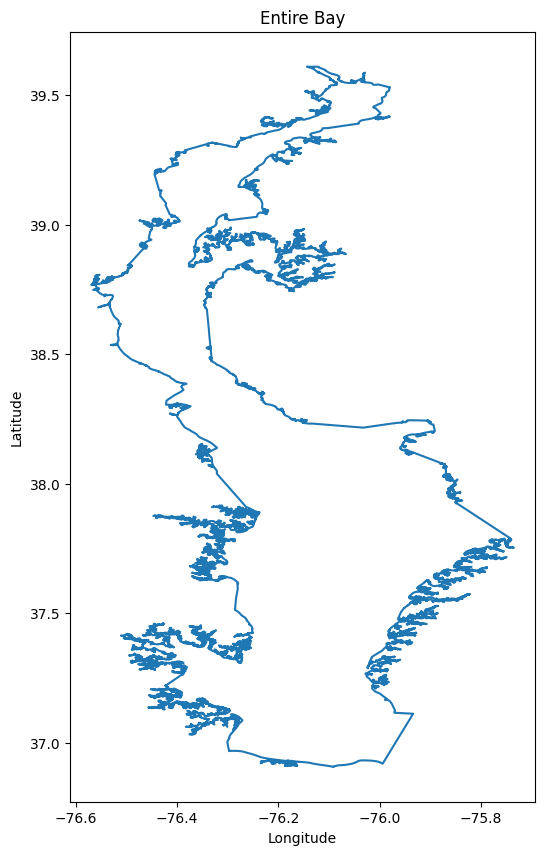

In [288]:
import matplotlib.pyplot as plt

# Adjust the figure size (width, height)
plt.figure(figsize=(6,10)) 

# Plot the polygon
x, y = combined_polygon.exterior.xy
plt.plot(x, y)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Entire Bay')

# Show the plot
plt.show()

Now we will create a latitude and longitude grid and use the polygon to restrict our data.

In [146]:
import numpy as np
import xarray as xr
from shapely.vectorized import contains
from tqdm.notebook import tqdm
import re
def assign_region_id(region):
    if region.startswith('CB'):
        region_number = int(re.search(r'(\d+)', region).group(1)) - 1
    elif region == "EASMH":
        region_number = 8
    elif region ==  "MOBPH":
        region_number = 9
    elif region == "TANMH":
        region_number = 10
    return region_number

def assign_salinity_zone(single_value):
    # Handle single value
    if isinstance(single_value, str):
        if single_value.endswith('TF'):
            return 0
        elif single_value.endswith('OH'):
            return 0.33
        elif single_value.endswith('MH'):
            return 0.67
        elif single_value.endswith('PH'):
            return 1
    return None



We will combine the latitude and longitude coordinates into one `position` coordinate. This will make it easier to restrict the data to the latitude and longitude points inside the Bay. We need to make sure this is done in a unique way, but we need a 1D representation that can be fed into our tensors.

In [8]:
cleaned_data

<xarray.Dataset>
Dimensions:          (time: 2767, depth: 1, lat: 358, lon: 243)
Coordinates:
  * time             (time) datetime64[ns] 2014-08-28T17:55:08 ... 2022-10-30...
  * depth            (depth) float64 0.0
  * lat              (lat) float64 40.01 40.0 39.99 39.98 ... 36.51 36.5 36.49
  * lon              (lon) float64 -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    chlor_a          (time, depth, lat, lon) float64 ...
    Air Temperature  (time, depth, lat, lon) float64 ...
    Air pressure     (time, depth, lat, lon) float64 ...
    Wind speed       (time, depth, lat, lon) float64 ...
    Wind Direction   (time, depth, lat, lon) float64 ...

In [85]:
import umap

def create_lat_lon_grid(ds):
    # Vectorized grid creation
    lon_coords = ds['lon'].values  # Longitude coordinates
    lat_coords = ds['lat'].values  # Latitude coordinates
    lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords, indexing='xy')

    return lon_grid, lat_grid 


def flatten_points_dict(ds):
    # Create a meshgrid of lat and lon
    lon_grid, lat_grid = create_lat_lon_grid(ds)

    # Flatten the meshgrid into coordinate pairs (for xarray points)
    lat_lon_grid = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))  # Xarray lat/lon pairs

    # Initialize UMAP model with verbose=True to track progress
    umap_model = umap.UMAP(n_components=1)

    # Fit and transform the data
    embedding = umap_model.fit_transform(lat_lon_grid).flatten()

    mapping = {tuple(lat_lon_grid[i]): embedding[i] for i in range(lat_lon_grid.shape[0])}

    return mapping

In [ ]:

umap_coord_dict= flatten_points_dict(cleaned_data)


In [75]:
def create_map_umap(masked_ds, mapping_dict):
    # Initialize the array for UMAP values
    index_mapping ={}
    umap_values = []

    for original_index in np.ndindex(*masked_ds.dims.values()):
        lat_index = original_index[-2]
        lon_index = original_index[-1]
        # Get latitude and longitude values
        lat_value = masked_ds['lat'].values[lat_index]
        lon_value = masked_ds['lon'].values[lon_index]

        # Check if (lat, lon) exists in mapping_dict
        umap_value = mapping_dict.get((lat_value, lon_value))

        # If a valid UMAP value exists, store it and its index
        if umap_value is not None:
            if umap_value in umap_values:
                valid_index = np.where(umap_values == umap_value)[0][0]  # Find valid_index
            else:
                umap_values.append(umap_value)  # Store the UMAP value
                valid_index = len(umap_values) - 1  # This gives the current index in the array

            # Optionally store the mapping of original_index to valid_index here
            # original_index = (lat_index, lon_index)  # Define how to get the original index
            index_mapping[original_index] = valid_index  # Store the mapping

    return umap_values, index_mapping

def create_1D_coords(masked_ds, mapping_dict):
    umap_values, index_mapping = create_map_umap(masked_ds, mapping_dict)
    
    new_data_shape = (masked_ds.dims['time'], int(len(umap_values)))  # use umap_values length
    new_data = np.full(new_data_shape, np.nan)
    new_ds = xr.Dataset()


    # for var in masked_ds.data_vars:
    for var in tqdm(masked_ds.data_vars, desc=f"Changing coordinates" , leave=False):
        original_values = masked_ds[var].values        

        # Populate new_data using the precomputed index_map
        for key in index_mapping.keys():
            new_data[key[0], index_mapping[key]] = original_values[key]

        # Assign the new_data to the data variable with umap_coord as an additional dimension
        new_ds[var] = xr.DataArray(new_data, dims=('time','umap_coord'), coords={'time' : masked_ds['time'].values, 'umap_coord': umap_values})

    return new_ds


def add_lat_long_back(new_masked_ds, mapping_dict):
    umap_values = new_masked_ds['umap_coord'].values
    # Reverse the dictionary for umap_value to (lat, lon)
    umap_to_lat_lon = {umap_value: (lat, lon) for (lat, lon), umap_value in mapping_dict.items()}

    # Extract lat and lon values using vectorized approach (with NaN for missing values)
    lat_values = np.array([umap_to_lat_lon.get(umap_value, (np.nan, np.nan))[0] for umap_value in umap_values])
    lon_values = np.array([umap_to_lat_lon.get(umap_value, (np.nan, np.nan))[1] for umap_value in umap_values])

    # Convert lat_values and lon_values into DataArrays and assign them to the xarray Dataset
    new_masked_ds = new_masked_ds.assign({
        'lat': xr.DataArray(lat_values, dims='umap_coord', coords={'umap_coord': umap_values}),
        'lon': xr.DataArray(lon_values, dims='umap_coord', coords={'umap_coord': umap_values})
    })

    # Verify that lat and lon have been added
    return new_masked_ds

In [88]:
def regional_polygon_mask(ds, polygon):
    lon_grid, lat_grid = create_lat_lon_grid(ds)
    mask_2d = contains(polygon, lon_grid.flatten(), lat_grid.flatten()).reshape(lon_grid.shape)

    # Convert the 2D mask to a DataArray with correct dimensions
    mask_expanded = xr.DataArray(mask_2d, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})

    # Apply the mask to all data variables in the dataset
    masked_ds = ds.where(mask_expanded)  # This sets outside measurements to NaN

    # Create a mask where all data variables are NaN across time, depth, and lon for each lat
    nan_mask_lat = masked_ds.isnull().all(dim=['lon', 'time'])  # Check across depth, lon, and time
    nan_mask_lon = masked_ds.isnull().all(dim=['lat', 'time'])  # Check across depth, lat, and time

    # Drop the coordinates where all data variables are NaN
    nan_mask = ~nan_mask_lat & ~nan_mask_lon  # Combine masks using logical AND
    masked_ds = masked_ds.where(nan_mask, drop=True)

    return masked_ds

In [77]:
def polygon_mask(ds, filtered_gdf,mapping_dict):
    masked_xarrays = {}  # Dictionary to store individual region xarrays

    # Initialize tqdm progress bar with a total count based on filtered_gdf
    with tqdm(total=len(filtered_gdf), desc="Creating xarrays regions") as outer_pbar:
        for idx, row in filtered_gdf.iterrows():
            with tqdm(total=5, desc=f"Processing region", leave=False) as inner_pbar:
                region_id = row['CBSEG_92']
                polygon = row['geometry']
                salinity_zone = assign_salinity_zone(row['CBSEG_92'])  # Assign Salinity Zone

                # Apply the mask to all data variables in the dataset
                masked_ds = regional_polygon_mask(ds, polygon)
                inner_pbar.update(2)  # Progress for applying mask

                new_coordinates_ds = create_1D_coords(masked_ds, mapping_dict)
                inner_pbar.update(2)
                
                new_mask = ~new_coordinates_ds.isnull().all(dim='time')
                new_masked_ds = new_coordinates_ds.where(new_mask, drop=True)
                
                salinity_zone_array = xr.DataArray(
                    salinity_zone * np.ones_like(new_masked_ds['chlor_a'].values),  # Assume a variable like chlor_a for shape
                    dims=('time', 'umap_coord'),
                    coords={'time': new_masked_ds['time'], 'umap_coord': new_masked_ds['umap_coord']}
                )
                
                new_masked_ds = new_masked_ds.assign({'Salinity_Zone': salinity_zone_array})

                new_masked_ds = add_lat_long_back(new_masked_ds,mapping_dict)

                # # Add Region ID as a new coordinate
                # Handle in dictionary/metadata
                # masked_ds = masked_ds.assign_coords({'RegionID': region_id})
                # masked_ds = masked_ds.expand_dims('RegionID')

                # Add metadata as attributes
                new_masked_ds.attrs['State'] = row['STATE']
                new_masked_ds.attrs['BasinGroup'] = row['BasinGroup']
                new_masked_ds.attrs['Name'] = row['Name']
                new_masked_ds.attrs['CBSeg2003'] = region_id

                masked_xarrays[region_id] = new_masked_ds


                print(f"xarray for {region_id}: {new_masked_ds.dims} ")
                inner_pbar.update(1)  # Progress for adding xarray
                
                outer_pbar.update(1)
    return masked_xarrays  # Return list of masked xarrays for each reg


In [ ]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] =='TANMH')
]

masked_xarrays = polygon_mask(cleaned_data, filtered_gdf, umap_coord_dict)

In [149]:
# List of variables to expand
variables_to_expand = ['lat', 'lon']

for region, region_data in masked_xarrays.items():

    # Expand variables to have dimensions (time, depth, lat, lon)
    for var in variables_to_expand:
        region_data[var] = region_data[var].expand_dims({'time': region_data.time})

In [150]:
for region, region_data in masked_xarrays.items():
    print(region)
    for var in region_data:
        data = region_data[var]
        total_values = np.prod(data.shape)
        nan_values = np.isnan(data).sum().item()
        percent_nan = (nan_values / total_values) * 100
        print(f"Percentage of NaN values in '{var}': {percent_nan:.2f}%")

CB1TF
Percentage of NaN values in 'chlor_a': 0.00%
Percentage of NaN values in 'Air Temperature': 0.00%
Percentage of NaN values in 'Air pressure': 0.00%
Percentage of NaN values in 'Wind speed': 0.00%
Percentage of NaN values in 'Wind Direction': 0.00%
Percentage of NaN values in 'Salinity_Zone': 0.00%
Percentage of NaN values in 'lat': 0.00%
Percentage of NaN values in 'lon': 0.00%
CB2OH
Percentage of NaN values in 'chlor_a': 0.00%
Percentage of NaN values in 'Air Temperature': 0.00%
Percentage of NaN values in 'Air pressure': 0.00%
Percentage of NaN values in 'Wind speed': 0.00%
Percentage of NaN values in 'Wind Direction': 0.00%
Percentage of NaN values in 'Salinity_Zone': 0.00%
Percentage of NaN values in 'lat': 0.00%
Percentage of NaN values in 'lon': 0.00%
CB3MH
Percentage of NaN values in 'chlor_a': 0.00%
Percentage of NaN values in 'Air Temperature': 0.00%
Percentage of NaN values in 'Air pressure': 0.00%
Percentage of NaN values in 'Wind speed': 0.00%
Percentage of NaN values

## Prepare to feed into the model

In [151]:
for region, region_data in masked_xarrays.items():
    index = assign_region_id(region)
    region_data.to_netcdf(f'../../data/filesForModel/nc4/satelliteBuoy_region{index}.nc4')

In [ ]:
# satellite_buoy = masked_xarray
#or if you skipped previous section
# satellite_buoy = xr.open_dataset('../../data/satelliteBuoy_clean_masked.nc4')
satellite_buoy_list= [] 
for i in range(11):
    satellite_buoy_list.append(xr.open_dataset(f"../../data/filesForModel/nc4/satelliteBuoy_region{i}.nc4"))

Now we can convert the xarray to a pytorch tensor for use in the model.

In [154]:
def xarray_to_tensors(ds):
    # Chlorophyll will not be a feature
    exclude_var = 'chlor_a'  
    included_vars = [var for var in ds.data_vars if var != exclude_var]

    # Convert all variables except the excluded one into a tensor
    data_arrays = [torch.tensor(ds[var].values,dtype=torch.float32) for var in ds.data_vars if var != exclude_var]

    # Stack the remaining tensors into one single tensor, adding a new dimension for the variables
    features_tensor = torch.stack(data_arrays, dim=1)
    # features_tensor = torch.nan_to_num(features_tensor, nan=0.0)

    # Create a dictionary mapping variable names to their corresponding tensor slices
    variable_indeces = {included_vars[i]: i for i in range(features_tensor.shape[1])}


    # Chlorophyll data
    chlorophyll_tensor = torch.tensor(ds[exclude_var].values,dtype=torch.float32)
    # chlorophyll_tensor = torch.nan_to_num(chlorophyll_tensor, nan=0.0)

    # For now, remove the depth dimension
    features_tensor = features_tensor.squeeze(1)
    chlorophyll_tensor = chlorophyll_tensor.squeeze(1)

    # Optional: Print shapes to confirm
    print(f"Features tensor shape: {features_tensor.shape}")
    print(f"Chlorophyll tensor shape: {chlorophyll_tensor.shape}")

    return features_tensor, chlorophyll_tensor, variable_indeces

In [155]:
satellite_buoy_tensors_dict = {}
variable_indeces_dict = {}
for region, region_data in masked_xarrays.items():
    idx = assign_region_id(region)
    features_tensor, chlorophyll_tensor,variable_indeces = xarray_to_tensors(region_data)
    satellite_buoy_tensors_dict[f'region_{idx}'] = {"Features": features_tensor,
                                                    "Chlorophyll": chlorophyll_tensor}
    variable_indeces_dict.update(variable_indeces)
    torch.save(features_tensor, f"../../data/filesForModel/tensors/features_region{idx}_tensor.pt")
    torch.save(chlorophyll_tensor, f"../../data/filesForModel/tensors/chlorophyll_region{idx}_tensor.pt")

with open('../../data/filesForModel/tensors/variable_indeces_dict.json', 'w') as f:
    json.dump(variable_indeces_dict,f)

Features tensor shape: torch.Size([2767, 7, 127])
Chlorophyll tensor shape: torch.Size([2767, 127])
Features tensor shape: torch.Size([2767, 7, 236])
Chlorophyll tensor shape: torch.Size([2767, 236])
Features tensor shape: torch.Size([2767, 7, 311])
Chlorophyll tensor shape: torch.Size([2767, 311])
Features tensor shape: torch.Size([2767, 7, 769])
Chlorophyll tensor shape: torch.Size([2767, 769])
Features tensor shape: torch.Size([2767, 7, 1234])
Chlorophyll tensor shape: torch.Size([2767, 1234])
Features tensor shape: torch.Size([2767, 7, 602])
Chlorophyll tensor shape: torch.Size([2767, 602])
Features tensor shape: torch.Size([2767, 7, 1251])
Chlorophyll tensor shape: torch.Size([2767, 1251])
Features tensor shape: torch.Size([2767, 7, 335])
Chlorophyll tensor shape: torch.Size([2767, 335])
Features tensor shape: torch.Size([2767, 7, 195])
Chlorophyll tensor shape: torch.Size([2767, 195])
Features tensor shape: torch.Size([2767, 7, 283])
Chlorophyll tensor shape: torch.Size([2767, 28

In [ ]:

# To save
with open('data.pkl', 'wb') as f:
    pickle.dump(your_dict, f)



In [166]:
import pickle

pickle.dump(umap_coord_dict, open('../../data/filesForModel/tensors/umap_coord_dict.pkl','wb'))

# Water Quality Dataset


## Read and clean water
For the water quality data, we will read in the CSV, drop columns that are not needed for the model. Let's drop the columns related to how the data was collected: `TotalDepth` refers to the station, `FieldActivityId`,`ProjectIdentifier`, and `Source`, `Problems`, and `Details` are about the sample collection.  `CBSeg2003` identifies the region of the Bay. `UpperPycnocline`, `LowerPycnocline`, and `Layer` are related to the layer of the water column.


In [4]:
water_quality_df = pd.read_csv('../../data/plank_ChesapeakeBayWater_pivoted.csv')

water_quality_df = water_quality_df.drop(columns=['FieldActivityId',
       'Cruise', 'ProjectIdentifier', 'Source', 'Layer', 'SampleType', 'Problem', 'Details','StationDepth','UpperPycnocline', 'LowerPycnocline'])

water_quality_timestamped = process_water_datetime(water_quality_df, 'SampleDate', 'SampleTime')

In [5]:
water_quality_timestamped.columns

Index(['CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD',
       'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PIP', 'PN',
       'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF', 'SIGMA_T', 'SPCOND', 'TDN',
       'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU', 'VSS', 'WTEMP',
       'CBSeg2003', 'Station', 'SampleDepth', 'Latitude', 'Longitude',
       'AirTemp', 'WindSpeed', 'WindDirection', 'PrecipType', 'TideStage',
       'WaveHeight', 'CloudCover', 'timestamp'],
      dtype='object')

Several of the text columns have a dictionary to convert to the existing numerical values. We will read in this dictionary to transform those columns into floats.

This dictionary comes from the [Water Quality Database Database Design and Data Dictionary](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf)


In [6]:
# Load JSON file
with open('../../data/waterQualityOtherColumns.json', 'r') as file:
    json_data = json.load(file)

# Function to convert integers to floats in a nested dictionary
def convert_numbers_to_floats(d):
    for key, value in d.items():
        if isinstance(value, dict):
            convert_numbers_to_floats(value)
        elif isinstance(value, int):
            d[key] = float(value)

# Convert numbers to floats in the loaded JSON data
convert_numbers_to_floats(json_data)

# Iterate through each column in the DataFrame
for column in water_quality_timestamped.columns:
    # Check if the column's dtype is not float
    if water_quality_timestamped[column].dtype != 'float':
        # Check if the column name exists in the JSON
        if column in json_data:
            # Fetch the corresponding inner dictionary from JSON
            inner_dict = json_data[column]

            # If the inner_dict values are floats, map them accordingly
            if all(isinstance(value, float) for value in inner_dict.values()):
                # Replace the column values based on the JSON data
                water_quality_timestamped[column] = water_quality_timestamped[column].map(lambda x: inner_dict.get(x, x))


We will keep variables that are floats.


In [7]:
water_filtered = water_quality_timestamped[['Station','CBSeg2003']].join(water_quality_timestamped.select_dtypes(include=['float', 'datetime']))

water_filtered.to_csv('../../data/water_cleaned.csv', index=False)

## Aggregate by date

In [176]:
satellite_buoy_for_aligning = xr.open_dataset('../../data/satelliteBuoy_clean.nc4')


We will aggregate the data by date and location using similar functions as the buoy data section. We will round latitude and longitude to 2 decimals, which is the same as the satellite data. Then we will group the data by day. Since we are not combining hte water quality data with the other datasets, we can turn this groupped data into an xarray to process for the model.

In [36]:
water_quality_data = pd.read_csv('../../data/water_cleaned.csv')
water_quality_data['timestamp'] = pd.to_datetime(water_quality_data['timestamp']).dt.date
water_quality_data.columns

Index(['Station', 'CBSeg2003', 'CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP',
       'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH',
       'PHEO', 'PIP', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF',
       'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU',
       'VSS', 'WTEMP', 'SampleDepth', 'Latitude', 'Longitude', 'AirTemp',
       'WindSpeed', 'WindDirection', 'WaveHeight', 'CloudCover', 'timestamp'],
      dtype='object')

Since the latitude and longitude values vary for the same station, we will use station as our location. We aggregate the based on day, Station, and SampleDepth. We also have to include CBSeg2003, as it is not a float.

In [191]:
water_quality_aggregated = water_quality_data.groupby(['Station', 'timestamp', 'SampleDepth','CBSeg2003']).mean().reset_index()

Now we will restrict to dates in the satelitte data

We need to deal with missing values before we continue. First, let's drop samples where chlorophyll is missing, since this is our target.


In [192]:
water_chla_restricted = water_quality_aggregated.dropna(subset=['CHLA'])

And now remove any variables that missing more than 10% of the values

In [193]:
threshold = .1

missing_percentage = water_chla_restricted.isnull().mean()

columns_to_keep = missing_percentage[missing_percentage <= threshold].index

# Create a new DataFrame with only the columns to keep
daily_aggregate = water_chla_restricted[columns_to_keep]
daily_aggregate = daily_aggregate.sort_values(['Latitude', 'Longitude','timestamp'])

print('Remaining columns:', daily_aggregate.columns)

Remaining columns: Index(['Station', 'timestamp', 'SampleDepth', 'CBSeg2003', 'CHLA', 'DO', 'PH',
       'PHEO', 'SALINITY', 'SECCHI', 'SIGMA_T', 'SPCOND', 'TSS', 'WTEMP',
       'Latitude', 'Longitude'],
      dtype='object')


Now we can clean up the remaining missing values.

In [154]:
from scipy.interpolate import griddata

daily_aggregate['timestamp'] = pd.to_datetime(daily_aggregate['timestamp'])
times = daily_aggregate['timestamp'].map(pd.Timestamp.timestamp)
lats = daily_aggregate['Latitude']
lons = daily_aggregate['Longitude']
depths = daily_aggregate['SampleDepth']  # Assuming this column exists for depth


# Step 3: Prepare the points for interpolation
points = np.array(list(zip(times, lats, lons)))

# List of columns to exclude from interpolation
exclude_columns = ['timestamp', 'Latitude', 'Longitude', 'CBSeg2003','Station','SampleDepth']

# Iterate over columns and apply the interpolation process
for col in daily_aggregate.columns:
    if col not in exclude_columns:
        values = daily_aggregate[col]

        # Filter out missing values for interpolation
        mask = ~np.isnan(values) & ~np.isnan(depths)  # Ensure depth is also valid
        valid_points = points[mask]
        valid_values = values[mask]

        # Interpolate to fill missing values
        interpolated_values = griddata(valid_points, valid_values, points, method='linear')

        # Replace the NaN values in the original column with interpolated values
        daily_aggregate[col] = np.where(np.isnan(values), interpolated_values, values)

# Normalize the interpolated values for all columns except CHLA
for col in daily_aggregate.columns:
    if col != 'CHLA' and col not in exclude_columns:
        min_val = daily_aggregate[col].min()
        max_val = daily_aggregate[col].max()

        # Normalize to the range [0, 1]
        daily_aggregate[col] = (daily_aggregate[col] - min_val) / (max_val - min_val)

# Apply QuantileTransformer to the 'CHLA' column
quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=1000, random_state=0)
daily_aggregate['CHLA'] = quantile_transformer.fit_transform(daily_aggregate[['CHLA']])
daily_aggregate = daily_aggregate.rename({"CHLA":"chlor_a"})

In [155]:
daily_aggregate.to_csv('../../data/water_aggregate_cleaned.csv',index=False)

## Align with grid from satelitte data

We will extract the latitude and longitude gride from the buoy data, then mask the same way.

In [175]:
satellite_buoy_for_aligning = xr.open_dataset('../../data/satelliteBuoy_clean.nc4')
water_daily_aggregate = pd.read_csv('../../data/water_aggregate_cleaned.csv')

Extract the latitude and longitude from the xarray and create an empty grid for out mask.

In [129]:
lat = satellite_buoy_for_size['lat'].values
lon = satellite_buoy_for_size['lon'].values

empty_dataset = xr.Dataset(
    coords={
        'lat': lat,
        'lon': lon
    },
    data_vars={"placeholder":(('lat','lon'), np.zeros((len(lat), len(lon))))}
)
empty_dataset

<xarray.Dataset>
Dimensions:      (lat: 358, lon: 243)
Coordinates:
  * lat          (lat) float64 40.01 40.0 39.99 39.98 ... 36.52 36.51 36.5 36.49
  * lon          (lon) float64 -77.51 -77.5 -77.49 ... -74.51 -74.5 -74.49
Data variables:
    placeholder  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [130]:
def regional_polygon_mask(ds, polygon):
    lon_grid, lat_grid = create_lat_lon_grid(ds)
    mask_2d = contains(polygon, lon_grid.flatten(), lat_grid.flatten()).reshape(lon_grid.shape)

    # Convert the 2D mask to a DataArray with correct dimensions
    mask_expanded = xr.DataArray(mask_2d, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})

    # Apply the mask to all data variables in the dataset
    masked_ds = ds.where(mask_expanded)  # This sets outside measurements to NaN

    # Create a mask where all data variables are NaN across time, depth, and lon for each lat
    nan_mask_lat = masked_ds.isnull().all(dim=['lon'])  # Check across depth, lon, and time
    nan_mask_lon = masked_ds.isnull().all(dim=['lat'])  # Check across depth, lat, and time

    # Drop the coordinates where all data variables are NaN
    nan_mask = ~nan_mask_lat & ~nan_mask_lon  # Combine masks using logical AND
    masked_ds = masked_ds.where(nan_mask, drop=True)

    return masked_ds

Now we will mask the empty data set to create grids for each region.

In [131]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] =='TANMH')
]

masked_grids_dict ={}
for index, row in tqdm(filtered_gdf.iterrows()):
    region = row['CBSEG_92']
    polygon = row['geometry']
    masked_grid = regional_polygon_mask(empty_dataset,polygon)
    masked_grids_dict[region] = masked_grid
    print(f"masked {region}")

2it [00:00, 10.78it/s]

masked CB1TF
masked CB2OH
masked CB3MH
masked CB4MH


11it [00:00, 26.74it/s]

masked CB5MH
masked CB6PH
masked CB7PH
masked CB8PH
masked EASMH
masked MOBPH
masked TANMH


We need to create a list of valid dates and valid depths for each region, which we will use for attaching the measured values to the grid.

In [210]:
water_daily_aggregate =water_daily_aggregate.applymap(lambda x: x.strip() if isinstance(x, str) else x)
group_by_region = {region: group for region, group in water_daily_aggregate.groupby('CBSeg2003')}

filtered_region_grid_dict = {}

# Step 3: Iterate over each group to populate the dictionary
for region, group in tqdm(group_by_region.items(), desc="Processing Regions"):
    # Get unique dates and depths for the region
    unique_dates = group['timestamp'].unique()
    unique_depths = group['SampleDepth'].unique()

    masked_data = masked_grids_dict[region]
    masked_data_filtered = masked_data.assign_coords(
    time=('time', unique_dates),
    depth=('depth', unique_depths),
    lat=('lat', masked_data.coords['lat'].values),  # Keep existing latitudes
    lon=('lon', masked_data.coords['lon'].values)   # Keep existing longitudes
    )

    masked_data_filtered = masked_data_filtered.drop('placeholder')
    masked_data_filtered = masked_data_filtered.transpose('time', 'depth', 'lat', 'lon')

    filtered_region_grid_dict[region] = masked_data_filtered




/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_31537/635433391.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  water_daily_aggregate =water_daily_aggregate.applymap(lambda x: x.strip() if isinstance(x, str) else x)
Processing Regions: 100%|██████████| 11/11 [00:00<00:00, 193.43it/s]


In [218]:
filtered_region_grid_dict['CB1TF']

<xarray.Dataset>
Dimensions:  (lat: 20, lon: 12, time: 413, depth: 18)
Coordinates:
  * lat      (lat) float64 39.6 39.59 39.58 39.57 ... 39.44 39.43 39.42 39.41
  * lon      (lon) float64 -76.12 -76.11 -76.1 -76.09 ... -76.01 -76.0 -75.99
  * time     (time) object '2007-04-24' '2007-05-30' ... '2021-08-25'
  * depth    (depth) float64 0.5 5.0 6.0 7.0 1.0 0.4 ... 0.3 1.2 1.3 1.5 4.0 3.0
Data variables:
    *empty*

In [166]:
def preprocess_dataframe_by_date(df):
    # Ensure 'Date' is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date

    grouped_data = {date: group for date, group in df.groupby('timestamp')}
    return grouped_data

water_dates_dict = preprocess_dataframe_by_date(water_daily_aggregate.drop(columns=['Station','CBSeg2003']))

In [219]:
def merge_and_clean_xarray(ds, grouped_data):
    try:
        
        # Define the variable with the date for the xarray
        for time_value in ds['time'].values:
            # Extract date for each time value
            date_value = pd.to_datetime(time_value).date()

            if date_value not in grouped_data:
                raise ValueError(f"No matching rows found for date: {date_value}")

            df_filtered = grouped_data[date_value]

            # Define where to find latitude and longitude
            latitudes = ds['lat'].values
            longitudes = ds['lon'].values
            depths = ds['depth'].values

            csv_lat = df_filtered['Latitude'].values
            csv_lon = df_filtered['Longitude'].values
            csv_depth = df_filtered['SampleDepth']
            
            lat_grid, lon_grid, depth_grid = np.meshgrid(latitudes, longitudes, depths, indexing='ij')

            # Flatten the meshgrid into coordinate pairs (for xarray points)
            points = np.column_stack((lat_grid.ravel(), lon_grid.ravel(), depth_grid.ravel()))  # Xarray lat/lon/depth pairs

            csv_points = np.column_stack((csv_lat, csv_lon, csv_depth))   # CSV lat/lon/depth points

            closest_data = {}
            for col in df_filtered.columns:
                if col not in ['Latitude', 'Longitude', 'timestamp','SampleDepth']:
                    # Extract the data values for the current variable
                    values = df_filtered[col].values  # Shape (n_csv_points,)

                    # Initialize the RBFInterpolator for the current variable
                    rbf_interpolator = RBFInterpolator(csv_points, values, kernel='linear')

                    # Perform the interpolation on the target points
                    interpolated_values = rbf_interpolator(points)  # Shape (n_lat * n_lon,)

                    # Reshape the interpolated values to match the xarray grid shape
                    interpolated_values = interpolated_values.reshape(lat_grid.shape)  # Shape (n_lat, n_lon)

                    # Assign the interpolated data to closest_data
                    closest_data[col] = interpolated_values


            new_ds = ds.copy(deep=True)
            for col, values in closest_data.items():
                new_ds[col] = (('time', 'depth', 'lat','lon'), values)  # Use 'lat' dimension for closest values

            return new_ds

    except Exception as e:
        raise RuntimeError(f"Error merging and cleaning xarray: {str(e)}")

In [220]:
water_xarray_dict = {}
for region, data_grid in tqdm(filtered_region_grid_dict.items(), desc="Processing Regions"):
    water_xarray = merge_and_clean_xarray(data_grid,water_dates_dict)
    water_xarray_dict[region] =water_xarray

Processing Regions:   0%|          | 0/11 [00:00<?, ?it/s]


RuntimeError: Error merging and cleaning xarray: Could not convert tuple of form (dims, data[, attrs, encoding]): (('time', 'depth', 'lat', 'lon'), array([[[0.05168422, 0.56891035, 0.5498598 , ..., 0.54498732,
         0.58629387, 0.59878225],
        [0.05079289, 0.56824812, 0.54932527, ..., 0.54179968,
         0.585425  , 0.59752556],
        [0.05112052, 0.56758388, 0.54878936, ..., 0.53861284,
         0.58455298, 0.59626342],
        ...,
        [0.07593897, 0.56287963, 0.54500016, ..., 0.51645776,
         0.57836432, 0.58728627],
        [0.08133141, 0.56220001, 0.54445355, ..., 0.51333194,
         0.57746864, 0.58598498],
        [0.08661972, 0.56151855, 0.54390565, ..., 0.5102199 ,
         0.57657019, 0.58467935]],

       [[0.05130523, 0.56941687, 0.55025947, ..., 0.54815384,
         0.58698197, 0.59983794],
        [0.04917274, 0.56875447, 0.54972486, ..., 0.54494333,
         0.58611271, 0.59858001],
        [0.04911117, 0.56809007, 0.54918887, ..., 0.54173316,
         0.58524031, 0.59731659],
        ...,
        [0.07614211, 0.5633845 , 0.54539899, ..., 0.51940504,
         0.57904854, 0.58832944],
        [0.08215907, 0.56270467, 0.54485228, ..., 0.51625349,
         0.57815237, 0.58702657],
        [0.08801009, 0.562023  , 0.54430427, ..., 0.51311557,
         0.57725341, 0.58571933]],

       [[0.051207  , 0.56992219, 0.55065834, ..., 0.55133857,
         0.58766822, 0.6008907 ],
        [0.04827051, 0.56925964, 0.55012365, ..., 0.54810506,
         0.5867986 , 0.59963155],
        [0.04748951, 0.56859507, 0.54958757, ..., 0.54487144,
         0.5859258 , 0.59836689],
        ...,
        [0.07646807, 0.56388821, 0.54579703, ..., 0.52236918,
         0.57973099, 0.58936988],
        [0.08323099, 0.56320818, 0.54525022, ..., 0.51919174,
         0.57883433, 0.58806545],
        [0.08973825, 0.5625263 , 0.5447021 , ..., 0.51602775,
         0.57793488, 0.58675662]],

       ...,

       [[0.05022852, 0.57783773, 0.55692554, ..., 0.60403344,
         0.59837813, 0.61727424],
        [0.03400186, 0.57717313, 0.55638981, ..., 0.60042373,
         0.59750359, 0.61599873],
        [0.01934499, 0.57650643, 0.55585265, ..., 0.59680551,
         0.59662569, 0.61471708],
        ...,
        [0.05770652, 0.57178241, 0.55205341, ..., 0.57142863,
         0.5903899 , 0.60558437],
        [0.07664969, 0.57109961, 0.55150519, ..., 0.56782162,
         0.58948665, 0.60425823],
        [0.09269368, 0.57041488, 0.55095563, ..., 0.56422502,
         0.58858042, 0.60292713]],

       [[0.05547409, 0.57832134, 0.55730982, ..., 0.60737997,
         0.59902942, 0.61826554],
        [0.03829751, 0.57765664, 0.55677404, ..., 0.60374686,
         0.59815464, 0.6169892 ],
        [0.02164448, 0.57698984, 0.55623682, ..., 0.60010466,
         0.59727649, 0.61570669],
        ...,
        [0.0529158 , 0.57226496, 0.55243716, ..., 0.57454748,
         0.59103863, 0.60656696],
        [0.07223258, 0.57158203, 0.55188887, ..., 0.57091342,
         0.59013504, 0.60523968],
        [0.08860914, 0.57089715, 0.55133923, ..., 0.56728955,
         0.58922846, 0.6039074 ]],

       [[0.06350894, 0.57880359, 0.55769319, ..., 0.61072509,
         0.59967844, 0.61925254],
        [0.04715939, 0.57813879, 0.55715736, ..., 0.60706868,
         0.59880343, 0.61797541],
        [0.03343576, 0.57747189, 0.5566201 , ..., 0.6034026 ,
         0.59792504, 0.61669206],
        ...,
        [0.05347597, 0.57274619, 0.55282002, ..., 0.57766577,
         0.59168518, 0.60754549],
        [0.07146434, 0.57206311, 0.55227166, ..., 0.57400475,
         0.59078126, 0.6062171 ],
        [0.0872699 , 0.5713781 , 0.55172196, ..., 0.57035371,
         0.58987434, 0.60488367]]])) to Variable.

Now we can mask the data the same way as before, except we do not need to assign a salinity zone.

In [81]:
import pickle

with open('../../data/filesForModel/tensors/umap_coord_dict.pkl', 'rb') as file:
    umap_coord_dict = pickle.load(file)


In [197]:
def water_coord_change(ds_dict, mapping_dict):
    masked_xarrays = {}  # Dictionary to store individual region xarrays

    # Initialize tqdm progress bar with a total count based on filtered_gdf
    with tqdm(total=len(ds_dict), desc="Creating xarrays regions") as outer_pbar:
        for region, masked_ds in ds_dict.items():

            new_coordinates_ds = create_1D_coords(masked_ds, mapping_dict)
            inner_pbar.update(2)
            
            new_mask = ~new_coordinates_ds.isnull().all(dim='time')
            new_masked_ds = new_coordinates_ds.where(new_mask, drop=True)

            new_masked_ds = add_lat_long_back(new_masked_ds,mapping_dict)

            # Add metadata as attributes
            new_masked_ds.attrs['State'] = row['STATE']
            new_masked_ds.attrs['BasinGroup'] = row['BasinGroup']
            new_masked_ds.attrs['Name'] = row['Name']
            new_masked_ds.attrs['CBSeg2003'] = region_id

            masked_xarrays[region] = new_masked_ds


            print(f"xarray for {region}: {new_masked_ds.dims} ")
            
            outer_pbar.update(1)
    return masked_xarrays  # Return list of masked xarrays for each reg


In [200]:
water_coord_change(water_xarray_dict,umap_coord_dict)

Creating xarrays regions:   0%|          | 0/11 [00:18<?, ?it/s]


IndexError: index 12 is out of bounds for axis 0 with size 12

In [91]:
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'] =='TANMH')
]

masked_water_xarrays = polygon_mask(water_full_xarray, filtered_gdf, umap_coord_dict)

Processing region:   0%|          | 0/5 [00:00<?, ?it/s]

Creating xarrays regions:   0%|          | 0/11 [00:00<?, ?it/s]


IndexError: list index out of range

## Aggregate by region

In [156]:
# Initialize an empty dictionary for regions
water_region_dict = {}
# Group by 'CBSeg2003' (region)
grouped = daily_aggregate.groupby('CBSeg2003')

# Iterate over each group to create the nested dictionary
for region, group in grouped:
    # Initialize a nested dictionary for the current region
    station_dict = {}
    
    # Group by 'Station' within the current region
    for station, station_group in group.groupby('Station'):
        # Store the DataFrame for each station in the nested dictionary
        station_dict[station] = station_group
    
    # Add the nested dictionary for the current region to the main dictionary
    water_region_dict[region] = station_dict

Since we are runnng the model on each individual region, we will create a dictionary with one dataframe per region. We will take the average value across all depths.

In [159]:
water_region_xarray_dict = {}

for region_id, station_dict in tqdm(water_region_dict.items(), desc="Processing regions"):
    station_xarray_dict = {}

    # Loop through the DataFrame in chunks
    for station_id, station_data in tqdm(station_dict.items(),"Processing Stations in {region_id}"):

        # Convert the chunk to xarray
        ds_station = station_data.set_index(['timestamp', 'Latitude', 'Longitude', 'SampleDepth']).to_xarray()
        ds_station = ds_station.drop_vars(['CBSeg2003', 'Station'])
        
        # ds_station_mean = ds_station.mean(dim='SampleDepth')

        station_xarray_dict[station_id] = ds_station
    
    water_region_xarray_dict[region_id] = station_xarray_dict

    # # # Concatenate all chunks into a single xarray dataset
    # ds_full = xr.concat(xarray_chunks, dim='timestamp')  # Use an appropriate dimension (e.g., 'timestamp')

    # water_region_xarray_dict[region_id] = ds_full



Processing regions:   0%|          | 0/11 [00:00<?, ?it/s]

Processing regions: 100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


In [160]:
water_region_xarray_dict['CB1TF ']['CB1.1']

<xarray.Dataset>
Dimensions:      (timestamp: 260, Latitude: 1, Longitude: 1, SampleDepth: 6)
Coordinates:
  * timestamp    (timestamp) datetime64[ns] 2004-08-11 2004-08-25 ... 2023-12-14
  * Latitude     (Latitude) float64 39.55
  * Longitude    (Longitude) float64 -76.08
  * SampleDepth  (SampleDepth) float64 0.5 3.0 4.0 5.0 6.0 7.0
Data variables:
    CHLA         (timestamp, Latitude, Longitude, SampleDepth) float64 0.485 ...
    DO           (timestamp, Latitude, Longitude, SampleDepth) float64 0.4494...
    PH           (timestamp, Latitude, Longitude, SampleDepth) float64 0.3412...
    PHEO         (timestamp, Latitude, Longitude, SampleDepth) float64 0.0587...
    SALINITY     (timestamp, Latitude, Longitude, SampleDepth) float64 1.931e...
    SECCHI       (timestamp, Latitude, Longitude, SampleDepth) float64 0.1094...
    SIGMA_T      (timestamp, Latitude, Longitude, SampleDepth) float64 0.0617...
    SPCOND       (timestamp, Latitude, Longitude, SampleDepth) float64 0.0037...
    TSS          (timestamp, Latitude, Longitude, SampleDepth) float64 0.0188...
    WTEMP        (timestamp, Latitude, Longitude, SampleDepth) float64 0.7362...